# Weather Dataset

In [1]:
!pip install windrose

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime, timedelta
from windrose import WindroseAxes
import matplotlib.cm as cm
import numpy as np

sns.set(rc={'figure.figsize':(13,13)})

C:\Users\AKHILSREEKAR\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 1. Data Import - Weather Dataset<a id='1'></a>

In [3]:
path = 'data/weather/'
file_name = 'weather.csv'
full_path = path + file_name

weather_df = pd.read_csv(full_path)
weather_df.shape

(331166, 10)

In [4]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331166 entries, 0 to 331165
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   timestamp       331166 non-null  object 
 1   site_id         331166 non-null  object 
 2   airTemperature  331038 non-null  float64
 3   cloudCoverage   160179 non-null  float64
 4   dewTemperature  330838 non-null  float64
 5   precipDepth1HR  197980 non-null  float64
 6   precipDepth6HR  18162 non-null   float64
 7   seaLvlPressure  309542 non-null  float64
 8   windDirection   318161 non-null  float64
 9   windSpeed       330592 non-null  float64
dtypes: float64(8), object(2)
memory usage: 25.3+ MB


Code below to reduce df memory size

In [5]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


In [6]:
weather_df = reduce_mem_usage(weather_df)

Mem. usage decreased to 10.11 Mb (60.0% reduction)


In [7]:
weather_df.head()

,timestamp,site_id,airTemperature,cloudCoverage,dewTemperature,precipDepth1HR,precipDepth6HR,seaLvlPressure,windDirection,windSpeed
0,2016-01-01 00:00:00,Panther,19.40625,NaN,19.40625,0.0,NaN,NaN,0.0,0.0
1,2016-01-01 01:00:00,Panther,21.09375,6.0,21.09375,-1.0,NaN,1019.5,0.0,0.0
2,2016-01-01 02:00:00,Panther,21.09375,NaN,21.09375,0.0,NaN,1019.0,210.0,1.5
3,2016-01-01 03:00:00,Panther,20.59375,NaN,20.00000,0.0,NaN,1018.0,0.0,0.0
4,2016-01-01 04:00:00,Panther,21.09375,NaN,20.59375,0.0,NaN,1019.0,290.0,1.5


## 2. Target Location Selection<a id='2'></a>

In [8]:
weather_df.site_id.value_counts()

Panther     17544
Gator       17544
Fox         17543
Bear        17542
Hog         17542
Rat         17539
Peacock     17539
Eagle       17536
Swan        17535
Bull        17529
Bobcat      17525
Shrew       17516
Robin       17516
Mouse       17516
Wolf        17505
Lamb        17500
Cockatoo    16975
Crow        16860
Moose       16860
Name: site_id, dtype: int64

Similar to the data wrangling process we did for buildings, we want to only pick the weather information we care about: "Moose (Ottawa, Ontario)", "Crow (Ottawa, Ontario)", "Hog (Minneapolis, Minnesota)", "Cockatoo (Cornell, New York)"

In [9]:
target_sites = ['Moose', 'Crow', 'Hog', 'Cockatoo']
weather_df = weather_df[weather_df.site_id.isin(target_sites)]

#replace site_id with real location's name
weather_df = weather_df.replace(to_replace='Moose', value='Ottawa_1')
weather_df = weather_df.replace(to_replace='Crow', value='Ottawa_2')
weather_df = weather_df.replace(to_replace='Hog', value='Minneapolis')
weather_df = weather_df.replace(to_replace='Cockatoo', value='Cornell')

weather_df.shape

(68237, 10)

In [10]:
weather_df.site_id.value_counts()

Minneapolis    17542
Cornell        16975
Ottawa_1       16860
Ottawa_2       16860
Name: site_id, dtype: int64

### 2.1 Location: Ottawa Data Investigation<a id='2.1'></a>

We notice that we have 2 locations as Ottawa. In theory, the weather information under site_ids "Ottawa_1" and 'Ottawa_2' should be the same. The fact that they have same amount of data (16860) is a hint. We will now confirm this. If we have a number of 16860 of duplicate items, then we can confirm that the weather information under both site_ids are the same.

In [11]:
ottawa_df = weather_df.loc[weather_df.site_id.isin(['Ottawa_1', 'Ottawa_2']), :]
ottawa_df

,timestamp,site_id,airTemperature,cloudCoverage,dewTemperature,precipDepth1HR,precipDepth6HR,seaLvlPressure,windDirection,windSpeed
122723,2016-01-01 00:00:00,Ottawa_1,-2.199219,NaN,-3.599609,NaN,NaN,1014.5,270.0,2.099609
122724,2016-01-01 01:00:00,Ottawa_1,-2.300781,NaN,-3.800781,NaN,0.0,1014.5,260.0,2.099609
122725,2016-01-01 02:00:00,Ottawa_1,-2.800781,NaN,-4.000000,NaN,NaN,1014.0,260.0,1.500000
122726,2016-01-01 03:00:00,Ottawa_1,-3.000000,NaN,-3.800781,5.0,NaN,1014.0,260.0,1.500000
122727,2016-01-01 04:00:00,Ottawa_1,-3.300781,NaN,-3.800781,NaN,NaN,1013.5,230.0,1.000000
...,...,...,...,...,...,...,...,...,...,...
209036,2017-12-31 19:00:00,Ottawa_2,-21.500000,NaN,-26.906250,NaN,0.0,1030.0,280.0,3.599609
209037,2017-12-31 20:00:00,Ottawa_2,-21.203125,NaN,-26.406250,NaN,NaN,1030.0,290.0,5.101562
209038,2017-12-31 21:00:00,Ottawa_2,-22.296875,NaN,-26.906250,NaN,NaN,1030.0,280.0,3.099609
209039,2017-12-31 22:00:00,Ottawa_2,-22.906250,NaN,-26.796875,NaN,NaN,1030.0,260.0,2.099609


In [12]:
ottawa_df = ottawa_df.drop(columns='site_id')
ottawa_df.duplicated().sum()

16860

This confirms the duplications. We are going to removal all data that associated with site_id "Ottawa_2" and change "Ottawa_1" to "Ottawa"

In [13]:
weather_df.drop(weather_df[weather_df['site_id'] == 'Ottawa_2'].index, inplace=True)
weather_df = weather_df.replace(to_replace='Ottawa_1', value='Ottawa')
weather_df.groupby('site_id')['airTemperature'].count()

site_id
Cornell        16973
Minneapolis    17540
Ottawa         16860
Name: airTemperature, dtype: int64

In [14]:
weather_df.head()

,timestamp,site_id,airTemperature,cloudCoverage,dewTemperature,precipDepth1HR,precipDepth6HR,seaLvlPressure,windDirection,windSpeed
122723,2016-01-01 00:00:00,Ottawa,-2.199219,NaN,-3.599609,NaN,NaN,1014.5,270.0,2.099609
122724,2016-01-01 01:00:00,Ottawa,-2.300781,NaN,-3.800781,NaN,0.0,1014.5,260.0,2.099609
122725,2016-01-01 02:00:00,Ottawa,-2.800781,NaN,-4.000000,NaN,NaN,1014.0,260.0,1.500000
122726,2016-01-01 03:00:00,Ottawa,-3.000000,NaN,-3.800781,5.0,NaN,1014.0,260.0,1.500000
122727,2016-01-01 04:00:00,Ottawa,-3.300781,NaN,-3.800781,NaN,NaN,1013.5,230.0,1.000000


In summary, we have 3 locations' weather information: Cornell, Minneapolis, and Ottawa. The fact that they have different counts is telling us we have some missing timeline. We will investigate later.

## 3. Data Understanding <a id='3'></a>

Before we jump into summarizing missing data. We use the information below to develop a understanding of our data. The information is from the data publisher.

- timestamp: date and time in the format YYYY-MM-DD hh:mm:ss. Local timezone.
- site_id: animal-code-name for the site.
- airTemperature: The temperature of the air in degrees Celsius (ºC).
- cloudCoverage: Portion of the sky covered in clouds, in oktas.
- dewTemperature: The dew point (the temperature to which a given parcel of air must be cooled at constant pressure and water 
- vapor content in order for saturation to occur) in degrees Celsius (ºC).
- precipDepth1HR: The depth of liquid precipitation that is measured over a one hour accumulation period (mm).
- precipDepth6HR: The depth of liquid precipitation that is measured over a six hour accumulation period (mm).
- seaLvlPressure: The air pressure relative to Mean Sea Level (MSL) (mbar or hPa).
- windDirection: The angle, measured in a clockwise direction, between true north and the direction from which the wind is blowing (degrees).
- windSpeed: The rate of horizontal travel of air past a fixed point (m/s).

### 3.1 Missing Values by Column<a id='3.1'></a>

In [15]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51377 entries, 122723 to 313649
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   timestamp       51377 non-null  object 
 1   site_id         51377 non-null  object 
 2   airTemperature  51373 non-null  float16
 3   cloudCoverage   16695 non-null  float16
 4   dewTemperature  51324 non-null  float16
 5   precipDepth1HR  22784 non-null  float16
 6   precipDepth6HR  4548 non-null   float16
 7   seaLvlPressure  49964 non-null  float16
 8   windDirection   50487 non-null  float16
 9   windSpeed       51339 non-null  float16
dtypes: float16(8), object(2)
memory usage: 2.0+ MB


In [16]:
def missing_summary(df):
    missing_sum = df.isnull().sum()
    missing_mean = df.isnull().mean() * 100
    
    missing_df = pd.concat([missing_sum,missing_mean], axis=1)
    missing_df.columns =['missing_count', '%']
    missing_df = missing_df.sort_values('missing_count', ascending=False)
    return missing_df

missing_summary(weather_df)

,missing_count,%
precipDepth6HR,46829,91.147790
cloudCoverage,34682,67.504915
precipDepth1HR,28593,55.653308
seaLvlPressure,1413,2.750258
windDirection,890,1.732293
dewTemperature,53,0.103159
windSpeed,38,0.073963
airTemperature,4,0.007786
timestamp,0,0.000000
site_id,0,0.000000


### 3.2 Timestamp <a id='3.2'></a>

In [17]:
weather_df['timestamp'] = pd.to_datetime(weather_df['timestamp'] )
weather_df['timestamp'].max() - weather_df['timestamp'].min()

Timedelta('730 days 23:00:00')

A quick google search tells me that there are 366 days in 2016 and 365 days in 2017. In total, we should have 731 in our dataset. Since we have 3 different locations. We will investigate individually.

In [18]:
start_time = pd.to_datetime('2016-01-01 00:00:00')
end_time = pd.to_datetime('2017-12-31 23:00:00')

dates = pd.date_range(start=start_time, end=end_time, freq='1H')
len(dates)

17544

This tells us that if we are not missing any data, we should have 17,544 data points for our weather information. A quick observation tells us that it is likely that we are not missing any weather information at location **Minneapolis**, further investigation is required.

## 4. Cornell Data<a id='4'></a>

In [19]:
cornell_df = weather_df.loc[weather_df['site_id'] == 'Cornell', :]
cornell_df.shape

(16975, 10)

### 4.1 Cornell - Missing Timestamp<a id='4.1'></a>

In [20]:
len(dates) - 16975

569

We are missing roughly 569 timestamp. 

In [21]:
cornell_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16975 entries, 296675 to 313649
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   timestamp       16975 non-null  datetime64[ns]
 1   site_id         16975 non-null  object        
 2   airTemperature  16973 non-null  float16       
 3   cloudCoverage   7791 non-null   float16       
 4   dewTemperature  16970 non-null  float16       
 5   precipDepth1HR  3606 non-null   float16       
 6   precipDepth6HR  1003 non-null   float16       
 7   seaLvlPressure  15798 non-null  float16       
 8   windDirection   16528 non-null  float16       
 9   windSpeed       16939 non-null  float16       
dtypes: datetime64[ns](1), float16(8), object(1)
memory usage: 663.1+ KB


In [22]:
cornell_df.head()

,timestamp,site_id,airTemperature,cloudCoverage,dewTemperature,precipDepth1HR,precipDepth6HR,seaLvlPressure,windDirection,windSpeed
296675,2016-01-01 07:00:00,Cornell,-1.0,NaN,-3.0,NaN,NaN,NaN,250.0,2.599609
296676,2016-01-01 08:00:00,Cornell,-1.0,NaN,-3.0,NaN,NaN,NaN,240.0,3.099609
296677,2016-01-01 09:00:00,Cornell,-1.0,NaN,-2.0,NaN,NaN,NaN,240.0,4.101562
296678,2016-01-01 10:00:00,Cornell,-1.0,NaN,-2.0,NaN,NaN,NaN,240.0,4.601562
296679,2016-01-01 11:00:00,Cornell,-1.0,NaN,-3.0,NaN,NaN,NaN,270.0,5.101562


In [23]:
cornell_df = cornell_df.set_index('timestamp').reindex(dates).reset_index()
cornell_df = cornell_df.rename(columns={'index':'timestamp'})

### 4.2 Cornell - Missing Data<a id='4.2'></a>

In [24]:
missing_summary(cornell_df)

,missing_count,%
precipDepth6HR,16541,94.282946
precipDepth1HR,13938,79.445964
cloudCoverage,9753,55.591655
seaLvlPressure,1746,9.952120
windDirection,1016,5.791154
windSpeed,605,3.448472
dewTemperature,574,3.271774
airTemperature,571,3.254674
site_id,569,3.243274
timestamp,0,0.000000


In [25]:
cornell_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17544 entries, 0 to 17543
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   timestamp       17544 non-null  datetime64[ns]
 1   site_id         16975 non-null  object        
 2   airTemperature  16973 non-null  float16       
 3   cloudCoverage   7791 non-null   float16       
 4   dewTemperature  16970 non-null  float16       
 5   precipDepth1HR  3606 non-null   float16       
 6   precipDepth6HR  1003 non-null   float16       
 7   seaLvlPressure  15798 non-null  float16       
 8   windDirection   16528 non-null  float16       
 9   windSpeed       16939 non-null  float16       
dtypes: datetime64[ns](1), float16(8), object(1)
memory usage: 548.4+ KB


### 4.3 Cornell - Site ID<a id='4.3'></a>

All site ID should be "Cornell"

In [26]:
cornell_df.site_id.fillna('Cornell', inplace=True)
cornell_df.site_id.value_counts()

Cornell    17544
Name: site_id, dtype: int64

### 4.4 Cornell - airTemperature & dewTemperature<a id='4.4'></a>

In [27]:
cornell_df['airTemperature'].describe().apply(lambda x:'%.3f' % x)

count    16973.000
mean           inf
std         10.617
min        -23.906
25%          1.100
50%          9.398
75%         17.797
max         33.906
Name: airTemperature, dtype: object

In [28]:
cornell_df['dewTemperature'].describe().apply(lambda x:'%.3f' % x)

count    16970.000
mean           inf
std         10.070
min        -26.703
25%         -3.301
50%          5.000
75%         12.797
max         24.406
Name: dewTemperature, dtype: object

We are missing around 3% data for air temperature and dew temperature. Base on my background in chemical engineering and Google, the dew point is the temperature at which the air can exactly hold the amount of moisture present. When raining, at any given temperature, the atmosphere can hold so much water vapour. So the dew point is equal to the room temperature. The comparison between air temperature and dew temperature is a good indication of humidity, which can affect building energy consumption. We will keep them and will investigate further in EDA to fill the missing values.

In [29]:
((cornell_df['airTemperature'] - cornell_df['dewTemperature']) < 0).sum()

0

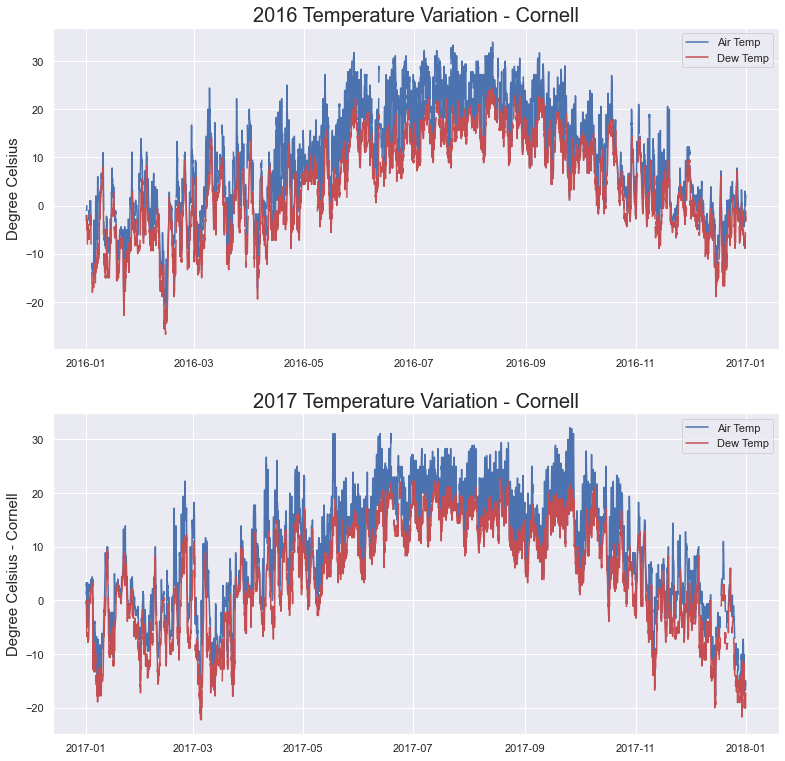

In [30]:
df_2016 = cornell_df.loc[cornell_df['timestamp'].dt.year == 2016, :]
df_2017 = cornell_df.loc[cornell_df['timestamp'].dt.year == 2017, :]

fig, ax = plt.subplots(2,1)

ax[0].plot(df_2016['timestamp'], df_2016['airTemperature'], linestyle=None, label='Air Temp')
ax[0].plot(df_2016['timestamp'], df_2016['dewTemperature'], linestyle=None, color = 'r', label='Dew Temp')
ax[0].set_title('2016 Temperature Variation - Cornell', fontsize=20)
ax[0].set_ylabel('Degree Celsius', fontsize=15)
ax[0].legend(loc='best')

ax[1].plot(df_2017['timestamp'], df_2017['airTemperature'], linestyle=None, label='Air Temp')
ax[1].plot(df_2017['timestamp'], df_2017['dewTemperature'], linestyle=None, color = 'r', label='Dew Temp')
ax[1].set_title('2017 Temperature Variation - Cornell', fontsize=20)
ax[1].set_ylabel('Degree Celsius - Cornell', fontsize=15)
ax[1].legend(loc='best')

def plot_weather(year1_df, year2_df, location):
    fig, ax = plt.subplots(2,1)

    ax[0].plot(year1_df['timestamp'], year1_df['airTemperature'], linestyle=None, label='Air Temp')
    ax[0].plot(year1_df['timestamp'], year1_df['dewTemperature'], linestyle=None, color = 'r', label='Dew Temp')
    ax[0].set_title(f'2016 Temperature Variation - {location}', fontsize=20)
    ax[0].set_ylabel('Degree Celsius', fontsize=15)
    ax[0].legend(loc='best')
    
    ax[1].plot(year2_df['timestamp'], year2_df['airTemperature'], linestyle=None, label='Air Temp')
    ax[1].plot(year2_df['timestamp'], year2_df['dewTemperature'], linestyle=None, color = 'r', label='Dew Temp')
    ax[1].set_title(f'2017 Temperature Variation - {location}', fontsize=20)
    ax[1].set_ylabel('Degree Celsius', fontsize=15)
    ax[1].legend(loc='best')

### 4.5 Cornell - windSpeed & windDirection<a id='4.5'></a>

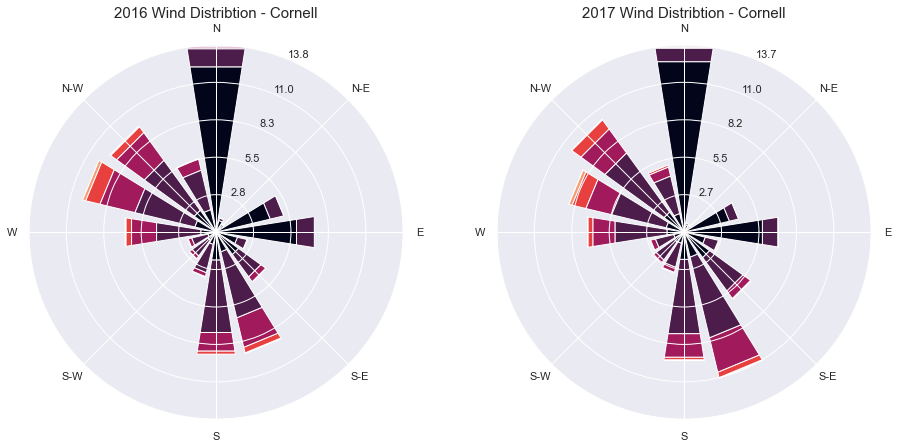

In [31]:
fig=plt.figure()

rect=[0.1, 0,0.4,0.4] 
wa=WindroseAxes(fig, rect)
fig.add_axes(wa)
wa.bar(df_2016['windDirection'], df_2016['windSpeed'], normed=True, opening=0.8, edgecolor='white')
wa.set_title('2016 Wind Distribtion - Cornell', fontsize=15)


rect1=[0.6, 0, 0.4, 0.4]
wa1=WindroseAxes(fig, rect1)
fig.add_axes(wa1)
wa1.bar(df_2017['windDirection'], df_2017['windSpeed'], normed=True, opening=0.8, edgecolor='white')
wa1.set_title('2017 Wind Distribtion - Cornell', fontsize=15)

def plot_wind(year1_df, year2_df, location):
    fig=plt.figure()

    rect=[0.1, 0,0.4,0.4] 
    wa=WindroseAxes(fig, rect)
    fig.add_axes(wa)
    wa.bar(year1_df['windDirection'], year1_df['windSpeed'], normed=True, opening=0.8, edgecolor='white')
    wa.set_title(f'2016 Wind Distribtion - {location}', fontsize=15)


    rect1=[0.6, 0, 0.4, 0.4]
    wa1=WindroseAxes(fig, rect1)
    fig.add_axes(wa1)
    wa1.bar(year2_df['windDirection'], year2_df['windSpeed'], normed=True, opening=0.8, edgecolor='white')
    wa1.set_title(f'2017 Wind Distribtion - {location}', fontsize=15)


In [32]:
# standardize dataframe names
cornell_df_2016 = df_2016
cornell_df_2017 = df_2017

# 5 Ottawa Data <a id='5'></a>

In [33]:
ottawa_df = weather_df.loc[weather_df['site_id'] == 'Ottawa', :]
ottawa_df.shape

(16860, 10)

### 5.1 Ottawa - Missing Timestamp  <a id='5.1'></a>

In [34]:
ottawa_df.shape

(16860, 10)

In [35]:
len(dates) - 16860

684

We are missing 684 data points.

In [36]:
ottawa_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16860 entries, 122723 to 139582
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   timestamp       16860 non-null  datetime64[ns]
 1   site_id         16860 non-null  object        
 2   airTemperature  16860 non-null  float16       
 3   cloudCoverage   0 non-null      float16       
 4   dewTemperature  16814 non-null  float16       
 5   precipDepth1HR  1687 non-null   float16       
 6   precipDepth6HR  2816 non-null   float16       
 7   seaLvlPressure  16826 non-null  float16       
 8   windDirection   16860 non-null  float16       
 9   windSpeed       16860 non-null  float16       
dtypes: datetime64[ns](1), float16(8), object(1)
memory usage: 658.6+ KB


In [37]:
ottawa_df.sort_values('timestamp').head()

,timestamp,site_id,airTemperature,cloudCoverage,dewTemperature,precipDepth1HR,precipDepth6HR,seaLvlPressure,windDirection,windSpeed
122723,2016-01-01 00:00:00,Ottawa,-2.199219,NaN,-3.599609,NaN,NaN,1014.5,270.0,2.099609
122724,2016-01-01 01:00:00,Ottawa,-2.300781,NaN,-3.800781,NaN,0.0,1014.5,260.0,2.099609
122725,2016-01-01 02:00:00,Ottawa,-2.800781,NaN,-4.000000,NaN,NaN,1014.0,260.0,1.500000
122726,2016-01-01 03:00:00,Ottawa,-3.000000,NaN,-3.800781,5.0,NaN,1014.0,260.0,1.500000
122727,2016-01-01 04:00:00,Ottawa,-3.300781,NaN,-3.800781,NaN,NaN,1013.5,230.0,1.000000


In [38]:
ottawa_df = ottawa_df.set_index('timestamp').reindex(dates).reset_index()
ottawa_df = ottawa_df.rename(columns={'index':'timestamp'})

### 5.2 Ottawa - Missing Data<a id='5.2'></a>

In [39]:
missing_summary(ottawa_df)

,missing_count,%
cloudCoverage,17544,100.000000
precipDepth1HR,15857,90.384177
precipDepth6HR,14728,83.948928
dewTemperature,730,4.160967
seaLvlPressure,718,4.092567
site_id,684,3.898769
airTemperature,684,3.898769
windDirection,684,3.898769
windSpeed,684,3.898769
timestamp,0,0.000000


In [40]:
ottawa_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17544 entries, 0 to 17543
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   timestamp       17544 non-null  datetime64[ns]
 1   site_id         16860 non-null  object        
 2   airTemperature  16860 non-null  float16       
 3   cloudCoverage   0 non-null      float16       
 4   dewTemperature  16814 non-null  float16       
 5   precipDepth1HR  1687 non-null   float16       
 6   precipDepth6HR  2816 non-null   float16       
 7   seaLvlPressure  16826 non-null  float16       
 8   windDirection   16860 non-null  float16       
 9   windSpeed       16860 non-null  float16       
dtypes: datetime64[ns](1), float16(8), object(1)
memory usage: 548.4+ KB


### 5.3 Ottawa - Site ID<a id='5.3'></a>

All site ID should be "Ottawa".

In [41]:
ottawa_df.site_id.fillna('Ottawa', inplace=True)
ottawa_df.site_id.value_counts()

Ottawa    17544
Name: site_id, dtype: int64

### 5.4 Ottawa - airTemperature & dewTemperature<a id='5.4'></a>

In [42]:
ottawa_df['airTemperature'].describe().apply(lambda x:'%.3f' % x)

count    16860.000
mean           inf
std         12.008
min        -28.797
25%         -0.700
50%          8.398
75%         17.703
max         33.906
Name: airTemperature, dtype: object

In [43]:
ottawa_df['dewTemperature'].describe().apply(lambda x:'%.3f' % x)

count    16814.000
mean         2.320
std         11.062
min        -35.000
25%         -5.199
50%          3.199
75%         11.500
max         22.906
Name: dewTemperature, dtype: object

We are missing around 3% - 4% data for air temperature and dew temperature. 

In [44]:
((ottawa_df['airTemperature'] - ottawa_df['dewTemperature']) < 0).sum()

0

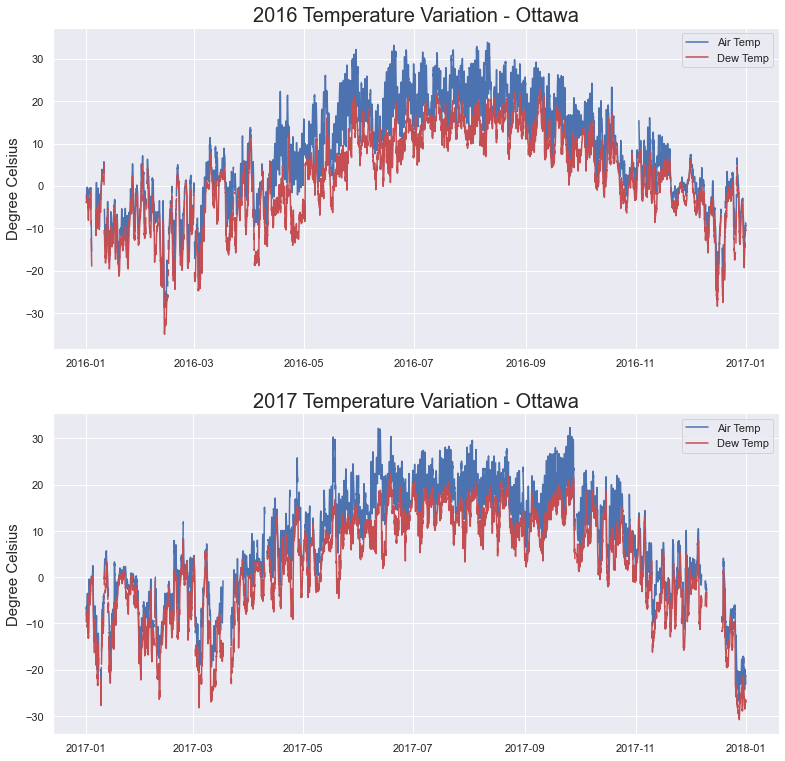

In [45]:
ottawa_df_2016 = ottawa_df.loc[ottawa_df['timestamp'].dt.year == 2016, :]
ottawa_df_2017 = ottawa_df.loc[ottawa_df['timestamp'].dt.year == 2017, :]

plot_weather(ottawa_df_2016, ottawa_df_2017, 'Ottawa')

### 5.5 Ottawa - windSpeed & windDirection<a id='5.5'></a>

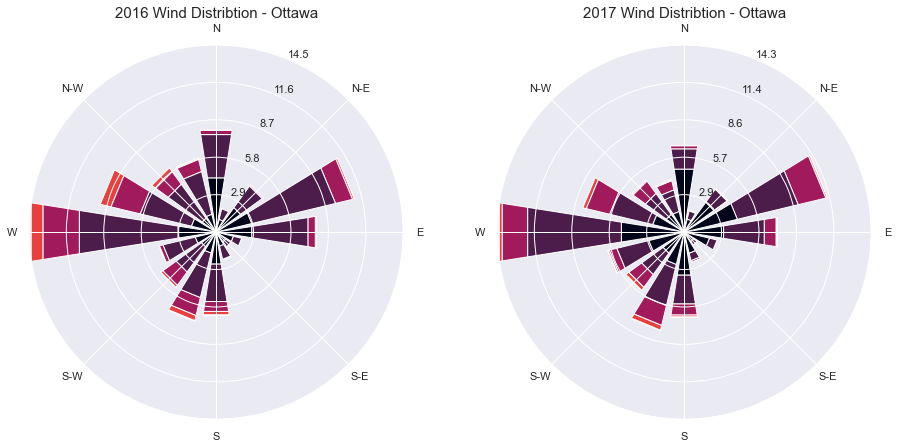

In [46]:
plot_wind(ottawa_df_2016, ottawa_df_2017, 'Ottawa')

## 6. Minneapolis  Data<a id='6'></a>

In [47]:
Minneapolis_df = weather_df.loc[weather_df['site_id'] == 'Minneapolis', :]
Minneapolis_df.shape

(17542, 10)

### 6.1 Minneapolis - Missing Timestamp  <a id='6.1'></a>

In [48]:
len(dates) - 1754

15790

In [49]:
Minneapolis_df.sort_values('timestamp').head()
Minneapolis_df = Minneapolis_df.set_index('timestamp').reindex(dates).reset_index()
Minneapolis_df = Minneapolis_df.rename(columns={'index':'timestamp'})

### 6.2 Minneapolis - Missing Data<a id='6.2'></a>

In [50]:
missing_summary(Minneapolis_df)

,missing_count,%
precipDepth6HR,16815,95.844733
cloudCoverage,8640,49.247606
windDirection,445,2.536480
seaLvlPressure,204,1.162791
precipDepth1HR,53,0.302098
airTemperature,4,0.022800
dewTemperature,4,0.022800
windSpeed,4,0.022800
site_id,2,0.011400
timestamp,0,0.000000


In [51]:
Minneapolis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17544 entries, 0 to 17543
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   timestamp       17544 non-null  datetime64[ns]
 1   site_id         17542 non-null  object        
 2   airTemperature  17540 non-null  float16       
 3   cloudCoverage   8904 non-null   float16       
 4   dewTemperature  17540 non-null  float16       
 5   precipDepth1HR  17491 non-null  float16       
 6   precipDepth6HR  729 non-null    float16       
 7   seaLvlPressure  17340 non-null  float16       
 8   windDirection   17099 non-null  float16       
 9   windSpeed       17540 non-null  float16       
dtypes: datetime64[ns](1), float16(8), object(1)
memory usage: 548.4+ KB


### 6.3 Minneapolis - Site ID<a id='6.3'></a>

In [52]:
Minneapolis_df.site_id.fillna('Minneapolis', inplace=True)
Minneapolis_df.site_id.value_counts()

Minneapolis    17544
Name: site_id, dtype: int64

### 6.4 Minneapolis - airTemperature & dewTemperature<a id='6.4'></a>

In [53]:
Minneapolis_df['airTemperature'].describe().apply(lambda x:'%.3f' % x)

count    17540.000
mean           inf
std         12.320
min        -28.906
25%          0.600
50%         11.102
75%         19.406
max         35.594
Name: airTemperature, dtype: object

In [54]:
Minneapolis_df['dewTemperature'].describe().apply(lambda x:'%.3f' % x)

count    17540.000
mean         2.971
std         11.328
min        -31.703
25%         -4.398
50%          3.301
75%         12.203
max         25.000
Name: dewTemperature, dtype: object

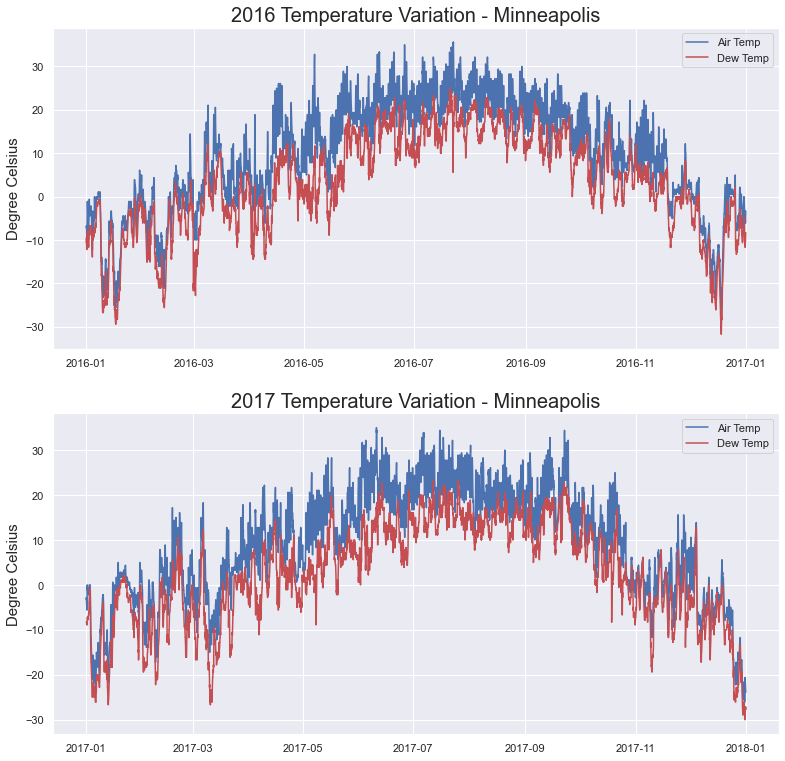

In [55]:
minneapolis_df_2016 = Minneapolis_df.loc[Minneapolis_df['timestamp'].dt.year == 2016, :]
minneapolis_df_2017 = Minneapolis_df.loc[Minneapolis_df['timestamp'].dt.year == 2017, :]

plot_weather(minneapolis_df_2016, minneapolis_df_2017, 'Minneapolis')

### 6.5 Minneapolis - windSpeed & windDirection<a id='6.5'></a>

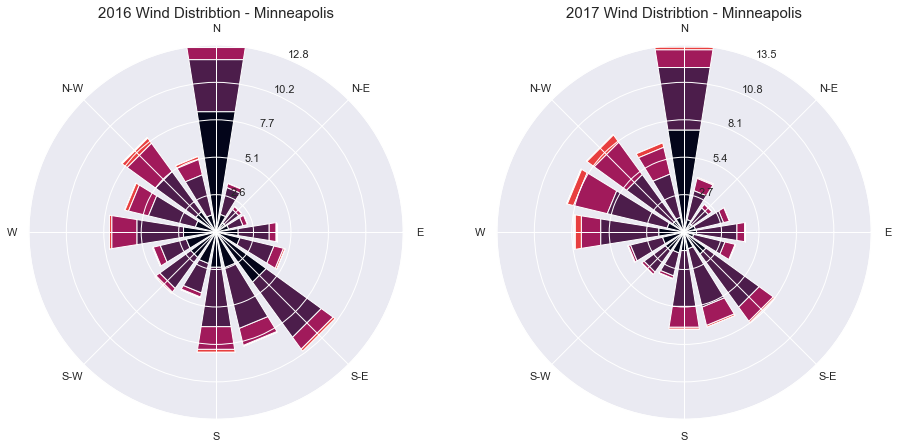

In [56]:
plot_wind(minneapolis_df_2016, minneapolis_df_2017, 'Minneapolis')

# 7 Save Data<a id='7'></a>

In [57]:
weather_cleaned_df = pd.concat([cornell_df,ottawa_df,Minneapolis_df])
weather_cleaned_df.site_id.value_counts()
weather_cleaned_df = weather_cleaned_df.reset_index()
weather_cleaned_df = weather_cleaned_df.drop(columns=['index'])

In [58]:
weather_cleaned_df.sort_values('timestamp')

,timestamp,site_id,airTemperature,cloudCoverage,dewTemperature,precipDepth1HR,precipDepth6HR,seaLvlPressure,windDirection,windSpeed
0,2016-01-01 00:00:00,Cornell,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17544,2016-01-01 00:00:00,Ottawa,-2.199219,NaN,-3.599609,NaN,NaN,1014.5,270.0,2.099609
35088,2016-01-01 00:00:00,Minneapolis,-7.199219,8.0,-10.601562,0.0,-1.0,1023.0,280.0,5.699219
1,2016-01-01 01:00:00,Cornell,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17545,2016-01-01 01:00:00,Ottawa,-2.300781,NaN,-3.800781,NaN,0.0,1014.5,260.0,2.099609
...,...,...,...,...,...,...,...,...,...,...
17542,2017-12-31 22:00:00,Cornell,-15.601562,NaN,-17.796875,-1.0,NaN,1028.0,290.0,5.699219
35086,2017-12-31 22:00:00,Ottawa,-22.906250,NaN,-26.796875,NaN,NaN,1030.0,260.0,2.099609
35087,2017-12-31 23:00:00,Ottawa,-23.093750,NaN,-27.093750,NaN,NaN,1030.0,280.0,2.599609
17543,2017-12-31 23:00:00,Cornell,-15.000000,NaN,-17.203125,-1.0,NaN,1028.0,310.0,6.699219


#### 7.1 Cleaning data

In [59]:
weather_cleaned_df.isna().sum()/len(weather_cleaned_df) * 100

timestamp          0.000000
site_id            0.000000
airTemperature     2.392081
cloudCoverage     68.279754
dewTemperature     2.485180
precipDepth1HR    56.710746
precipDepth6HR    91.358869
seaLvlPressure     5.069159
windDirection      4.075467
windSpeed          2.456680
dtype: float64

We missing 68% of the cloud coverage data, 60% - 90% of precipitation data. We will be remove them.

In [60]:
weather_cleaned_df = weather_cleaned_df.drop(columns=['cloudCoverage', 
                                      'precipDepth1HR', 
                                      'precipDepth6HR'])

In [61]:
file_name = path + 'weather_cleaned.csv'
weather_cleaned_df.to_csv(file_name)